In [1]:
# import libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools
import torch
import random
import time

# import Koopman Libraries
from core.koopman_core_linear import KoopDNN_linear, KoopmanNet_linear, KoopmanNetCtrl_linear
from sklearn import preprocessing
from core.util import fit_standardizer
from models.koop_model import model_matricies,lift

# Import Adaptive Koopman
from core.adapt_net_linear_test import AdaptNet_linear
import scipy.io

# Import Robot Dynamics
from dynamics.robot_selector import robot_selector
from dynamics.data_gen_robot import data_gen_robot_multi



## Robot Generation

In [2]:
# robot_selcetion
robot_type = "5R"
modality = "3D"
robot_name = robot_type + "_" + modality

In [3]:
# robot pars
robot_pars = {}
robot_pars['m'] = 0.1
robot_pars['I'] = np.eye(3)
robot_pars['l'] = 0.33

# robot parameters changed
robot_pars_changed = {}
robot_pars_changed ['m'] = 0.1
robot_pars_changed ['I'] = 1.5*np.eye(3)
robot_pars_changed ['l'] = 0.33

In [4]:
# get robots
robot = robot_selector(robot_name,robot_pars)
robot_changed = robot_selector(robot_name,robot_pars_changed)

In [5]:
print(robot)
print(robot_changed)

DHRobot: 5R_3D, 5 joints (RRRRR), dynamics, standard DH parameters
┌────┬────┬──────┬───────┐
│θⱼ  │ dⱼ │  aⱼ  │  ⍺ⱼ   │
├────┼────┼──────┼───────┤
│ q1 │  0 │ 0.33 │  0.0° │
│ q2 │  0 │ 0.33 │ 90.0° │
│ q3 │  0 │ 0.33 │  0.0° │
│ q4 │  0 │ 0.33 │ 90.0° │
│ q5 │  0 │ 0.33 │  0.0° │
└────┴────┴──────┴───────┘

┌─┬──┐
└─┴──┘

DHRobot: 5R_3D, 5 joints (RRRRR), dynamics, standard DH parameters
┌────┬────┬──────┬───────┐
│θⱼ  │ dⱼ │  aⱼ  │  ⍺ⱼ   │
├────┼────┼──────┼───────┤
│ q1 │  0 │ 0.33 │  0.0° │
│ q2 │  0 │ 0.33 │ 90.0° │
│ q3 │  0 │ 0.33 │  0.0° │
│ q4 │  0 │ 0.33 │ 90.0° │
│ q5 │  0 │ 0.33 │  0.0° │
└────┴────┴──────┴───────┘

┌─┬──┐
└─┴──┘



## Data Generation

In [6]:
dt = 0.02 #time step #50 Hz and 200Hz
num_train = 100 # no. of training examples
num_val = int(0.25*num_train) # no of testing examples
num_traj = num_train+num_val #no of trajectories
num_snaps = 1000 # no. of snapshots
controller = 'controller' # controller used or not for data generation
num_joints = robot.random_q().shape[0]
num_states = 2*robot.random_q().shape[0]
num_inputs = num_joints

if robot.name.__contains__("2D"):
    num_states_cart = 2
else:
    num_states_cart = 3
T = np.linspace(0,num_snaps*dt,num_snaps)

In [7]:
X_end_unchanged,X_unchanged, X_end_changed, X_changed, U = data_gen_robot_multi(dt,num_traj,num_snaps, robot, robot_changed, controller)
print(X_changed.shape, U.shape)

(125, 1000, 10) (125, 999, 5)


In [8]:
# Check for nan values
print(sum(sum(sum(np.isnan(X_changed)))))
print(sum(sum(sum(np.isnan(X_unchanged)))))

0
0


In [9]:
# change in dynamics
# l2 change
l2_diff = np.linalg.norm(X_changed-X_unchanged)/((X_changed.size)**(1/2))
print('l2_diff = ', l2_diff)

# fractional change
change_in_dym = np.linalg.norm((X_changed-X_unchanged)/X_changed)/X_changed.size
print('fraction of change in dynamics = ', change_in_dym)

l2_diff =  4.031694924055892
fraction of change in dynamics =  0.19651040269725928


/tmp/ipykernel_7658/388285069.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(num_joints,2,2*i+1)
/tmp/ipykernel_7658/388285069.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(num_joints,2,2*i+2)


Text(0.5, 0.98, 'Original Dynamics')

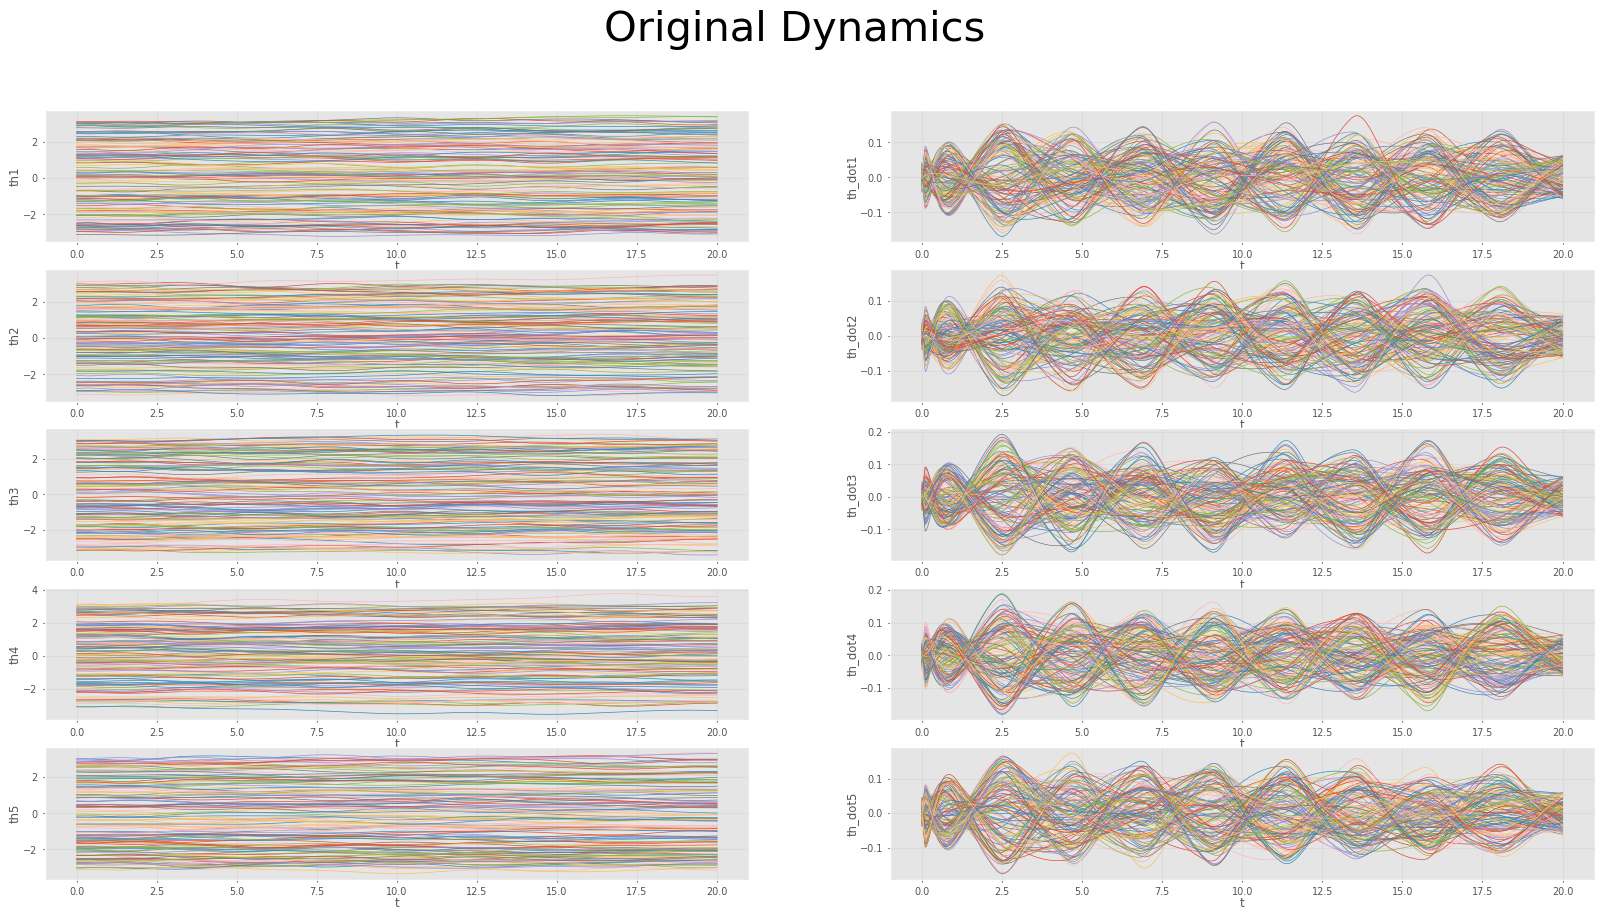

In [10]:
# Overall data
plt.figure(figsize = (20,10))

for j in range(num_traj):
    for i in range(int(num_joints)):
        plt.subplot(num_joints,2,2*i+1)
        plt.xlabel("t")
        plt.ylabel("th"+str(i+1))
        plt.plot(T,X_unchanged[j,:,i])
        plt.subplot(num_joints,2,2*i+2)
        plt.xlabel("t")
        plt.ylabel("th_dot"+str(i+1))
        plt.plot(T,X_unchanged[j,:,num_joints+i])
plt.suptitle("Original Dynamics", fontsize=30)

/tmp/ipykernel_7658/1780861094.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(num_joints,2,2*i+1)
/tmp/ipykernel_7658/1780861094.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(num_joints,2,2*i+2)


Text(0.5, 0.98, 'Changed Dynamics')

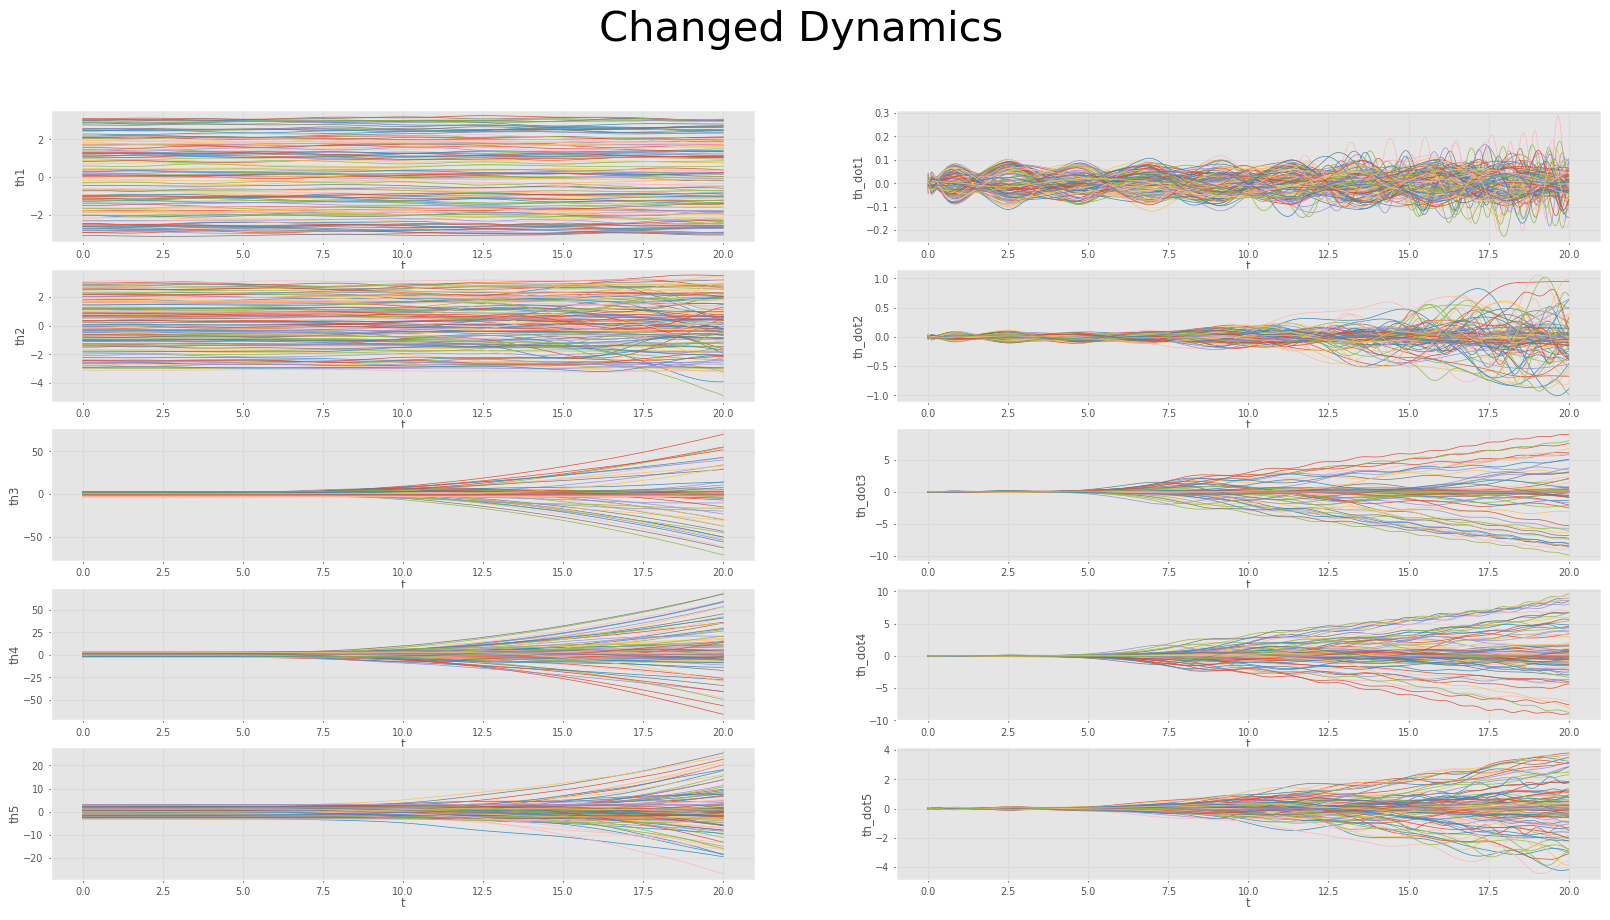

In [11]:
# Overall data
plt.figure(figsize = (20,10))

for j in range(num_traj):
    for i in range(int(num_joints)):
        plt.subplot(num_joints,2,2*i+1)
        plt.xlabel("t")
        plt.ylabel("th"+str(i+1))
        plt.plot(T,X_changed[j,:,i])
        plt.subplot(num_joints,2,2*i+2)
        plt.xlabel("t")
        plt.ylabel("th_dot"+str(i+1))
        plt.plot(T,X_changed[j,:,num_joints+i])
plt.suptitle("Changed Dynamics", fontsize=30)

/tmp/ipykernel_7658/1725726399.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(num_joints,1,i+1)


Text(0.5, 0.98, 'Control Inputs')

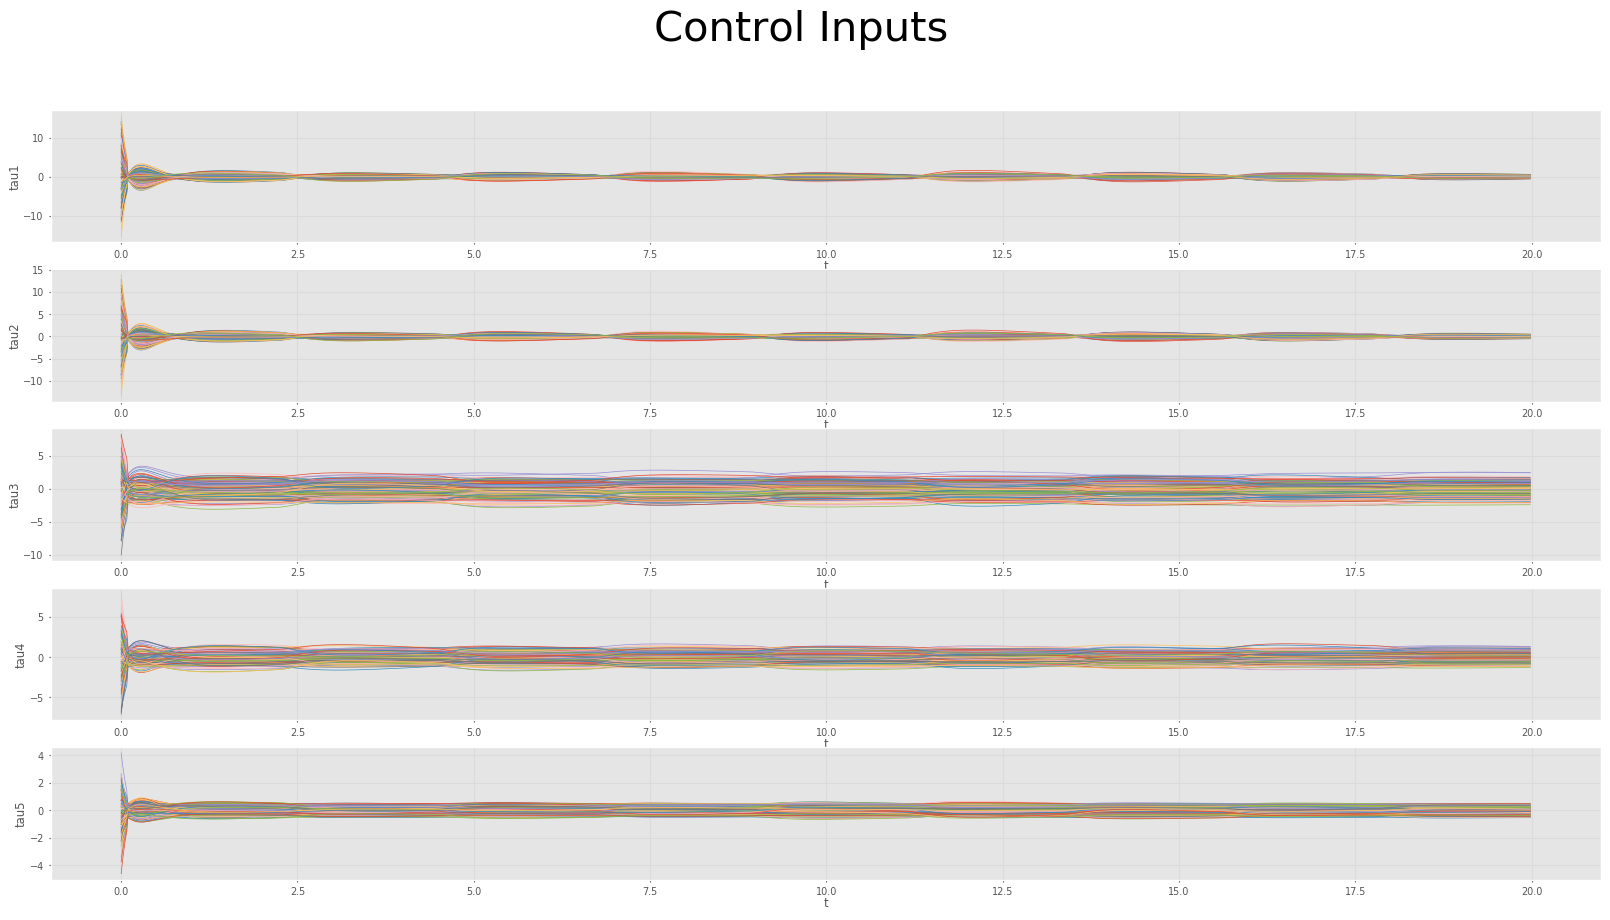

In [12]:
plt.figure(figsize = (20,10))

for j in range(num_traj):
    for i in range(int(num_joints)):
        plt.subplot(num_joints,1,i+1)
        plt.xlabel("t")
        plt.ylabel("tau"+str(i+1))
        plt.plot(T[:-1],U[j,:,i])
plt.suptitle("Control Inputs", fontsize=30)

Text(0.5, 0.98, 'Difference in Dynamics')

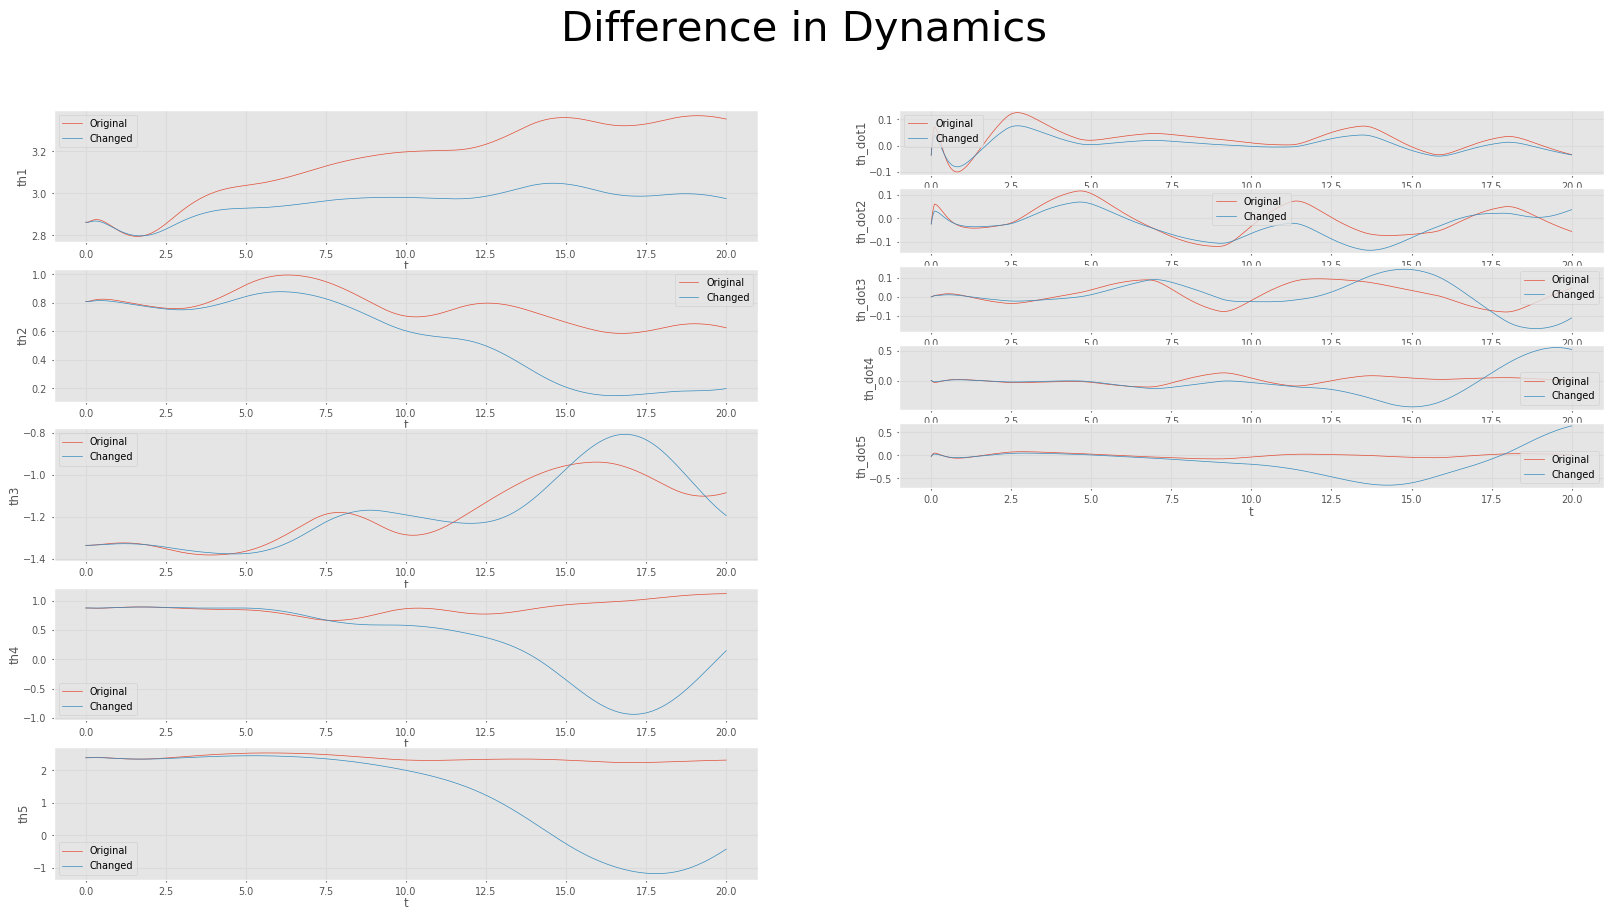

In [13]:
## difference in dynamics
plt.figure(figsize= (20,10))

j = random.randrange(0,num_traj)
for i in range(int(num_joints)):
    plt.subplot(num_joints,2,2*i+1)
    plt.xlabel("t")
    plt.ylabel("th"+str(i+1))
    plt.plot(T,X_unchanged[j,:,i], label = 'Original')
    plt.plot(T,X_changed[j,:,i], label = 'Changed')
    plt.legend()
    plt.subplot(num_states,2,2*i+2)
    plt.xlabel("t")
    plt.ylabel("th_dot"+str(i+1))
    plt.plot(T,X_unchanged[j,:,num_joints+i], label = "Original")
    plt.plot(T,X_changed[j,:,num_joints+i], label = "Changed")   
    plt.legend()
plt.suptitle("Difference in Dynamics", fontsize=30)

## Learning Koopman Models

In [14]:
# split training and vaidation datasets
xs_train, us_train = X_unchanged[:num_train,:,:],U[:num_train,:,:]
xs_val, us_val = X_unchanged[num_train:,:,:],U[num_train:,:,:]

In [15]:
# auto encoder parameters
net_params = {}
net_params['state_dim'] = num_states
net_params['ctrl_dim'] = num_inputs
net_params['encoder_hidden_width'] = 30
net_params['encoder_hidden_depth'] = 2
net_params['encoder_output_dim'] = 10
net_params['optimizer'] = 'adam'
net_params['activation_type'] = 'tanh'
net_params['lr'] = 5e-4 # 5e-4
net_params['epochs'] = 100
net_params['batch_size'] = 256
net_params['lifted_loss_penalty'] = 0.3
net_params['l2_reg'] = 0.0         
net_params['l1_reg'] = 0.0
net_params['first_obs_const'] = True
net_params['override_C'] = True # this makes the state a part of lifted state
net_params['dt'] = dt

In [16]:
# Koopman Model
train = True
file = 'saved_models/manipulators/linear/'+ robot_type + '/' + modality + '/Koop_arch.pth'
if train == True:
    net = KoopmanNetCtrl_linear(net_params)
    model_koop_dnn = KoopDNN_linear(net)
    model_koop_dnn.set_datasets(xs_train, u_train=us_train, x_val=xs_val, u_val=us_val)
    model_koop_dnn.model_pipeline(net_params)
    model_koop_dnn.construct_koopman_model()
    torch.save(model_koop_dnn,file)
else:
    model_koop_dnn = torch.load(file)

Epoch   1: train loss: 1.1287884712, validation loss: 1.0334465735
Epoch   2: train loss: 0.9311114550, validation loss: 0.9500127064
Epoch   3: train loss: 0.8720469475, validation loss: 0.9048458447
Epoch   4: train loss: 0.8304285407, validation loss: 0.8713522389
Epoch   5: train loss: 0.7969253659, validation loss: 0.8433573231
Epoch   6: train loss: 0.7632765770, validation loss: 0.8189943190
Epoch   7: train loss: 0.7290375233, validation loss: 0.7878045370
Epoch   8: train loss: 0.6961274147, validation loss: 0.7611541564
Epoch   9: train loss: 0.6665647626, validation loss: 0.7446679887
Epoch  10: train loss: 0.6429700255, validation loss: 0.7350721054
Epoch  11: train loss: 0.6237803698, validation loss: 0.7270453493
Epoch  12: train loss: 0.6065276861, validation loss: 0.7228105506
Epoch  13: train loss: 0.5901718140, validation loss: 0.7169183368
Epoch  14: train loss: 0.5750976205, validation loss: 0.7124044377
Epoch  15: train loss: 0.5581377745, validation loss: 0.708205

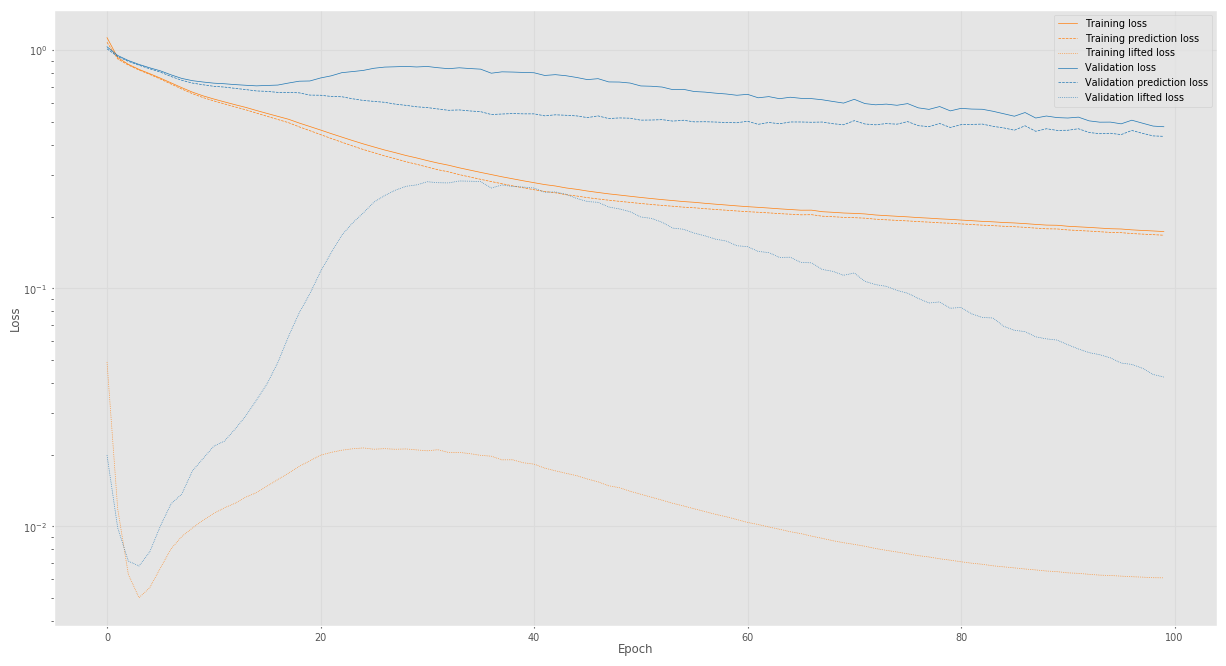

In [17]:
train_loss = [l[0] for l in model_koop_dnn.train_loss_hist]
train_pred_loss = [l[1] for l in model_koop_dnn.train_loss_hist]
train_lifted_loss = [l[2] for l in model_koop_dnn.train_loss_hist]
val_loss = [l[0] for l in model_koop_dnn.val_loss_hist]
val_pred_loss = [l[1] for l in model_koop_dnn.val_loss_hist]
val_lifted_loss = [l[2] for l in model_koop_dnn.val_loss_hist]
epochs = np.arange(0, net_params['epochs'])

plt.figure(figsize=(15,8))
plt.plot(epochs, train_loss, color='tab:orange', label='Training loss')
plt.plot(epochs, train_pred_loss, '--', color='tab:orange', label='Training prediction loss')
plt.plot(epochs, train_lifted_loss, ':', color='tab:orange', label='Training lifted loss')
plt.plot(epochs, val_loss, color='tab:blue', label='Validation loss')
plt.plot(epochs, val_pred_loss, '--', color='tab:blue', label='Validation prediction loss')
plt.plot(epochs, val_lifted_loss, ':', color='tab:blue', label='Validation lifted loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

## Koopman Model Parameters

In [18]:
A = np.array(model_koop_dnn.A)
B = np.array(model_koop_dnn.B)
C = np.array(model_koop_dnn.C)

print(A.shape, B.shape, C.shape)

(21, 21) (21, 5) (10, 21)


## Testing

In [19]:
# test data parameters
num_snaps_test = 1000 # no. of snapshots
T_test = np.linspace(0,num_snaps_test*dt, num_snaps_test)
num_traj_test = 1 # no. of training examples
first_obs_const = int(net_params['first_obs_const']) #only one state
override_C = net_params['override_C']
if override_C:
    n_obs = int(net_params['encoder_output_dim']) + num_states + first_obs_const 
else:
    n_obs = int(net_params['encoder_output_dim']) + first_obs_const 

In [20]:
x_end_unchanged_test,x_unchanged_test,x_end_changed_test, x_changed_test, u_test = data_gen_robot_multi(dt,num_traj_test,num_snaps_test, robot, robot_changed, controller)
print(model_koop_dnn.test_loss(x_unchanged_test,u_test = u_test))

tensor(0.2808)


In [21]:
x_unchanged_test.shape

(1, 1000, 10)

In [22]:
# Use the preprocessing if available
X_unchanged_t,_ = model_koop_dnn.net.process(x_unchanged_test,data_u = u_test)
X_changed_t,_ = model_koop_dnn.net.process(x_changed_test,data_u = u_test)

In [23]:
X_changed_t.shape

(999, 25)

In [24]:
# flatten vector
x_unchanged_t = X_unchanged_t[:, :num_states]
u_t = X_unchanged_t[:, num_states:num_states+num_inputs]
x_unchanged_prime_t = X_unchanged_t[:,num_states+num_inputs:]

x_changed_t = X_changed_t[:, :num_states]
x_changed_prime_t = X_changed_t[:,num_states+num_inputs:]

x_changed_dot_t = (x_changed_prime_t-x_changed_t)/dt
print(x_changed_t.shape, u_t.shape, x_changed_prime_t.shape)

(999, 10) (999, 5) (999, 10)


In [25]:
# initialize states
# initialize the matricies
z_unchanged_t = np.empty((n_obs,num_snaps_test)).T   #lifted state
x_unchanged_est_t = np.zeros((num_states,num_snaps_test)).T #estimated values

# actual lift
z_unchanged_t[0,:] = lift(x_unchanged_t[0,:],model_koop_dnn, net_params)
x_unchanged_est_t[0,:] = x_unchanged_t[0,:]

In [26]:
for i in range(num_snaps_test-1):
  #bilinear
    z_unchanged_t[i+1,:] = np.matmul(z_unchanged_t[i,:],A.T)+np.matmul(u_t[i,:],B.T)
    x_unchanged_est_t[i+1,:] = np.matmul(z_unchanged_t[i+1,:],C.T)

Text(0.5, 0.98, 'Testing Performance')

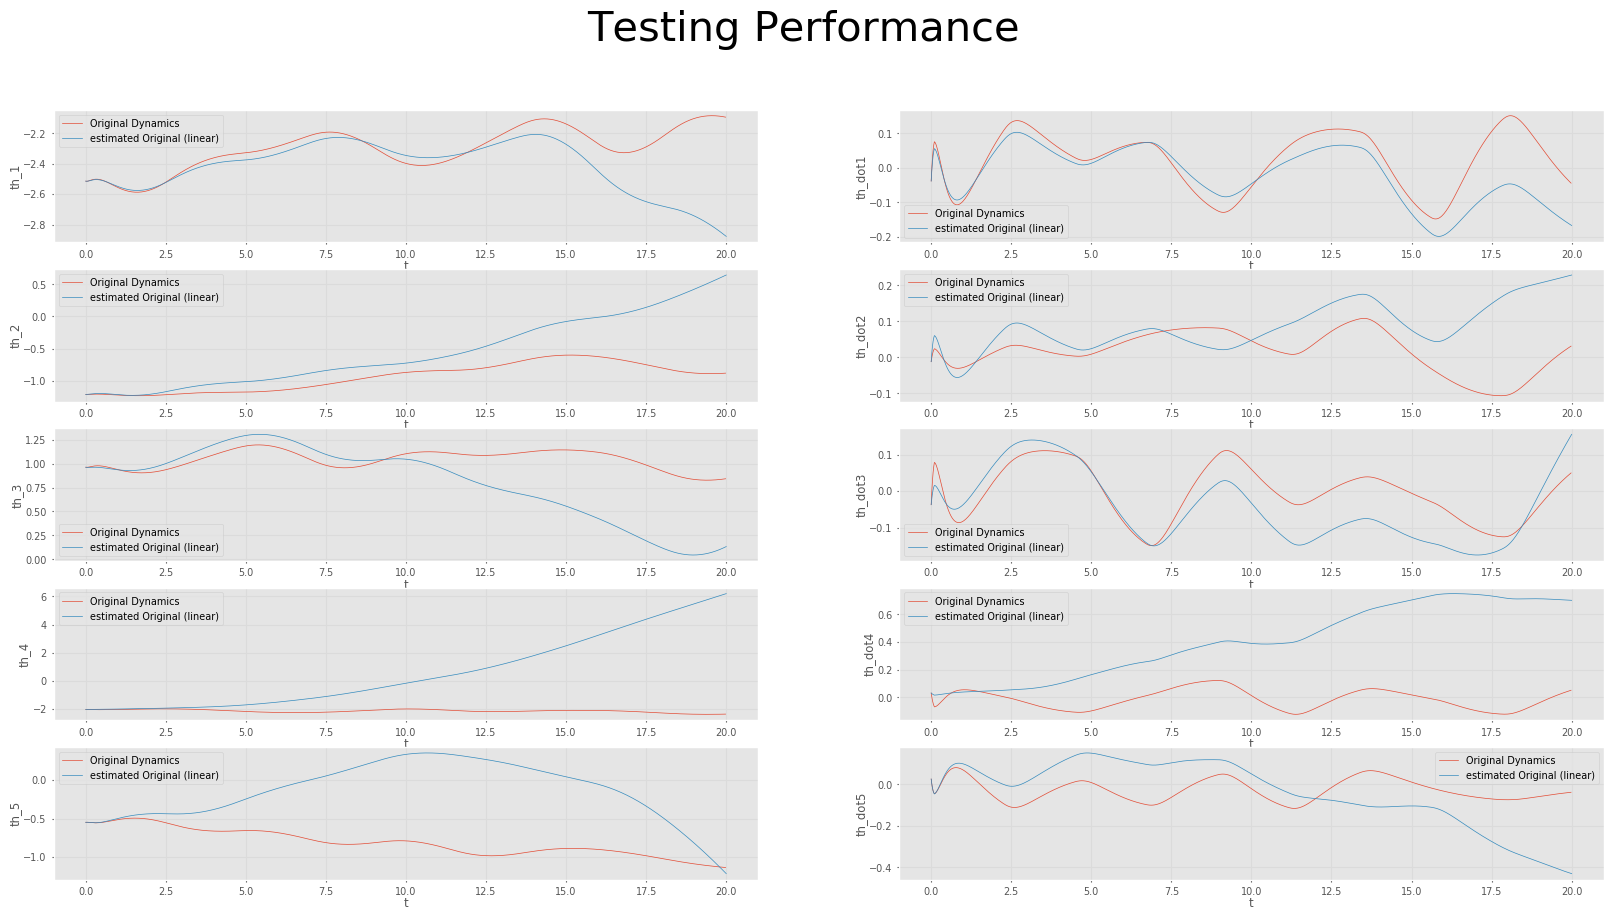

In [27]:
# state estimation evolution
plt.figure(figsize=(20, 10)) 

for i in range(num_joints):
    plt.subplot(num_joints, 2, 2*i +1)
    plt.plot(T_test[:-1],x_unchanged_t[:,i],label ='Original Dynamics')
    plt.plot(T_test[:],x_unchanged_est_t[:,i],label = 'estimated Original (linear)')
    plt.xlabel('t')
    plt.ylabel('th_' + str(i+1))
    plt.legend()
    
    plt.subplot(num_joints, 2, 2*i + 2)
    plt.plot(T_test[:-1],x_unchanged_t[:,num_joints+i],label ='Original Dynamics')
    plt.plot(T_test[:],x_unchanged_est_t[:,num_joints+i],label = 'estimated Original (linear)')
    plt.xlabel('t')
    plt.ylabel('th_dot' + str(i+1))
    plt.legend()
plt.suptitle("Testing Performance", fontsize=30)


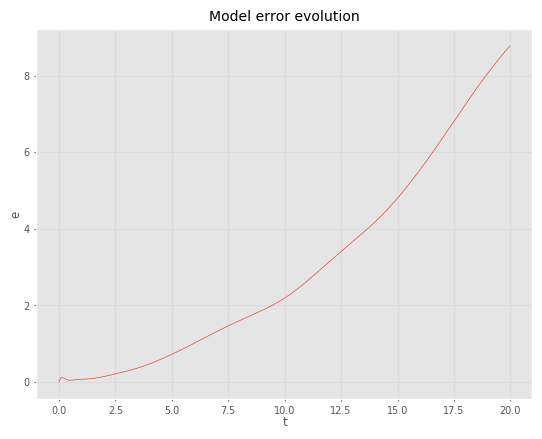

In [28]:
# error estimation
error_model_t = np.linalg.norm((x_unchanged_est_t[:-1,:]-x_unchanged_t[:,:]),axis=1)
error_dynamics_no_adapt_t = np.linalg.norm((x_changed_t[:,:]-x_unchanged_t[:,:]),axis=1)

plt.figure()
plt.plot(T_test[:-1],error_model_t)
plt.xlabel('t')
plt.ylabel('e')
plt.title('Model error evolution')
plt.show()

Text(0.5, 0.98, 'Change in Dynamics')

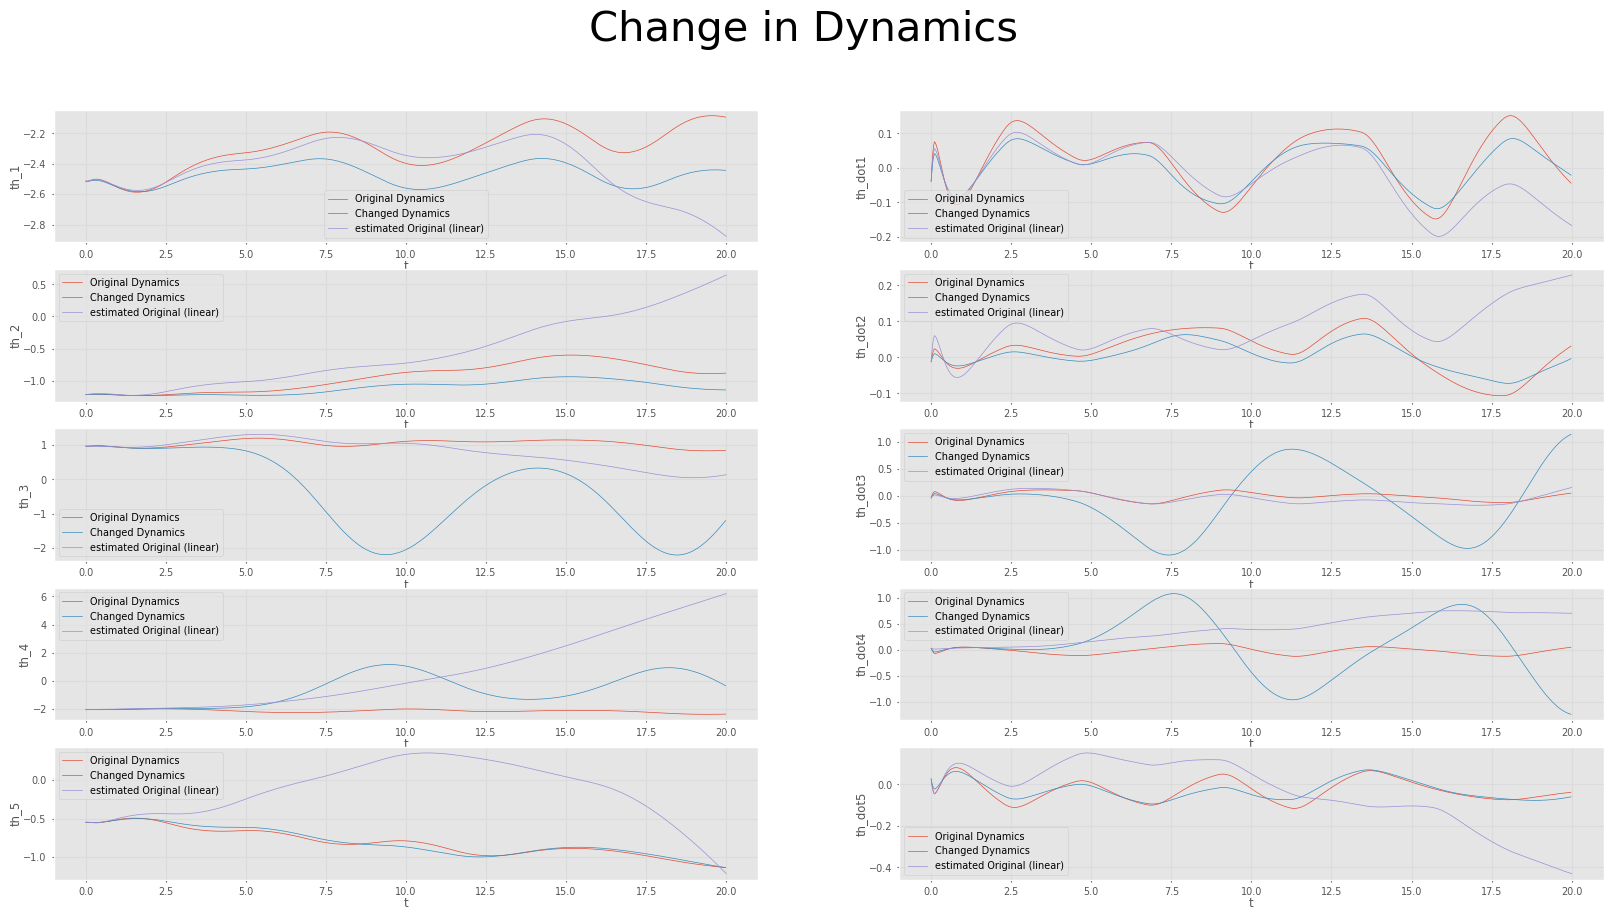

In [29]:
# comparison with Chnaged dynamics
plt.figure(figsize=(20, 10)) 

for i in range(num_joints):
    plt.subplot(num_joints, 2, 2*i +1)
    plt.plot(T_test[:-1],x_unchanged_t[:,i],label ='Original Dynamics')
    plt.plot(T_test[:-1],x_changed_t[:,i],label ='Changed Dynamics')
    plt.plot(T_test[:],x_unchanged_est_t[:,i],label = 'estimated Original (linear)')
    plt.xlabel('t')
    plt.ylabel('th_' + str(i+1))
    plt.legend()
    
    plt.subplot(num_joints, 2, 2*i + 2)
    plt.plot(T_test[:-1],x_unchanged_t[:,num_joints+i],label ='Original Dynamics')
    plt.plot(T_test[:-1],x_changed_t[:,num_joints+i],label  ='Changed Dynamics')
    plt.plot(T_test[:],x_unchanged_est_t[:,num_joints+i],label = 'estimated Original (linear)')
    plt.xlabel('t')
    plt.ylabel('th_dot' + str(i+1))
    plt.legend()
plt.suptitle("Change in Dynamics", fontsize=30)


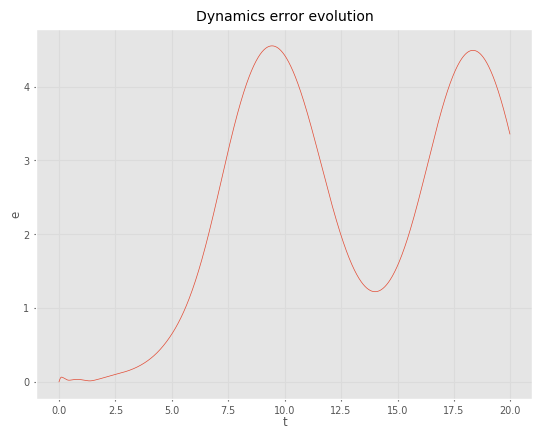

In [30]:
plt.figure()
plt.plot(T_test[:-1],error_dynamics_no_adapt_t)
plt.xlabel('t')
plt.ylabel('e')
plt.title('Dynamics error evolution')
plt.show()

## Adaptive Koopman with Control

In [31]:
# adaptive net parameters
adap_window = 10 #hyperparameter

adapt_net_params = {}
adapt_net_params['state_dim'] = num_states
adapt_net_params['ctrl_dim'] = num_inputs
adapt_net_params['lift_dim'] = net_params["encoder_output_dim"]
adapt_net_params['optimizer'] = 'adam'
adapt_net_params['lr'] = 5e-4 # 5e-4
adapt_net_params['epochs'] = 8
adapt_net_params['batch_size'] = adap_window
adapt_net_params['l2_reg'] = 5e-1
adapt_net_params['l1_reg'] = 5e-1
adapt_net_params['first_obs_const'] = net_params["first_obs_const"]
adapt_net_params['override_C'] = net_params["override_C"] # this makes the state a part of lifted state
adapt_net_params['warm_start'] = False

del_A = np.zeros_like(A)
del_B = np.zeros_like(B)

adapt_net_params['del_A_prev'] = del_A
adapt_net_params['del_B_prev'] = del_B

In [32]:
from control_files.nmpc_osqp_adapt import NonlinearMPCController
from dynamics.learned_models_control.linear_dynamics import linear_Dynamics
import scipy

In [33]:
# model objects for MPC
linear_model = linear_Dynamics(scipy.sparse.csc_matrix(A),scipy.sparse.csc_matrix(B), C)
linear_model_no_adapt = linear_Dynamics(scipy.sparse.csc_matrix(A),scipy.sparse.csc_matrix(B), C)
linear_model.A

<21x21 sparse matrix of type '<class 'numpy.float32'>'
	with 421 stored elements in Compressed Sparse Column format>

In [34]:
# OSQP solver setting
solver_settings = {}
solver_settings['gen_embedded_ctrl'] = False
solver_settings['warm_start'] = True
solver_settings['polish'] = True
solver_settings['polish_refine_iter'] = 3
solver_settings['scaling'] = True
solver_settings['adaptive_rho'] = False
solver_settings['check_termination'] = 25
solver_settings['max_iter'] = 1000
solver_settings['eps_abs'] = 1e-5
solver_settings['eps_rel'] = 1e-6
solver_settings['eps_prim_inf'] = 1e-4
solver_settings['eps_dual_inf'] = 1e-4
solver_settings['linsys_solver'] = 'qdldl'

In [35]:
#Closed loop performance evaluation parameters:
traj_length = 1000
max_iter = 200
N =  15 #length of horizon
t_eval = dt * np.arange(traj_length+1)                       # Simulation time points, closed loop
Q_mpc = 1e6*scipy.sparse.diags(np.ones(num_states))                       # State penalty matrix, trajectory generation
QN_mpc = 1e2*scipy.sparse.diags(np.ones(num_states))         # Final state penalty matrix, trajectory generation
R_mpc = 10*scipy.sparse.eye(num_inputs)                                     # Actuation penalty matrix, trajectory generation
R0_mpc = 10*scipy.sparse.csc_matrix(np.zeros(num_inputs))

In [38]:
## linear path
# x_ref = np.vstack((np.vstack((np.linspace(0,np.pi,num_snaps_ctrl),np.linspace(0,np.pi/2,num_snaps_ctrl))),np.linspace(0,np.pi,num_snaps_ctrl)))
# x_ref_dot = np.vstack((np.vstack(((np.pi/10)*np.ones(num_snaps_ctrl),(np.pi/20)*np.ones(num_snaps_ctrl))),(np.pi/10)*np.ones(num_snaps_ctrl)))
# x_ref_ddot = np.vstack((np.vstack((np.zeros(num_snaps_ctrl),np.zeros(num_snaps_ctrl))),np.zeros(num_snaps_ctrl)))

def gen_desired_path(num_states,num_snaps, t_end,shape):
    
    x_ref = np.empty((int(num_states),num_snaps))
    x_ref_dot = np.empty_like(x_ref)
    x_ref_ddot = np.empty_like(x_ref)
    
    arg = np.linspace(0,np.pi,num_snaps)
    
    for i in range(num_snaps):
        if shape == 'linear':
            x_ref[:,i] = np.ones((num_states,))*arg[i]
            x_ref_dot[:,i] = np.ones((num_states,))*[arg[-1]/t_end
            x_ref_ddot[:,i] = np.zeros((num_states,))

        if shape == 'sinosoidal':
            x_ref[:,i] = np.ones((num_states,))*np.sin(2*arg[i])
            x_ref_dot[:,i] = np.ones((num_states,))*(2*arg[-1]/t_end)*np.cos(2*arg[i])
            x_ref_ddot[:,i] = np.ones((num_states,))*((-2*arg[-1]/t_end)**2)*np.cos(2*arg[i])
        else:
            print('Shape is not defined')
            break
            
            
    return x_ref, x_ref_dot, x_ref_ddot

SyntaxError: invalid syntax (3174203078.py, line 19)

In [37]:
x_ref_pos, x_ref_dot,_  = gen_desired_path(int(num_states/2),traj_length+1, t_eval[-1],'sinosoidal')
x_ref = np.vstack((x_ref_pos, x_ref_dot))
x_ref.shape

ValueError: could not broadcast input array from shape (4,) into shape (5,)

In [ ]:
# Design trajectory:
xt = np.empty((traj_length+1, num_states))
xt[0,:] = x_ref[:,0]               # Initial value, closed loop trajectory

# x_r = np.array([0., 0.])              # Desired final value, closed loop trajectory
# x_ref = np.tile(x_r.reshape(-1,1), (1, traj_length))
umax = 30*np.ones((num_joints,))
umin = -umax

xmax =  30*np.ones((num_states))
xmin = -xmax

# Define initial solution for SQP algorithm:
x_init = np.linspace(xt[0,:], xt[0,:], N+1)
u_init = 1*np.ones((num_inputs, N)).T

In [ ]:
n_lift = A.shape[0]
z_init = np.empty((N+1, n_lift))
z0 = lift(xt[0,:], model_koop_dnn, net_params)
for i in range(N+1):
    z_init[i,:] = lift(x_init[i,:], model_koop_dnn, net_params)

In [ ]:
# initialize state matricies
u = np.empty((traj_length, num_inputs))
z_new_dyn = np.empty((n_obs, traj_length+1)).T   #lifted state
zt_old_dyn = np.empty((n_obs, traj_length+1)).T #actual lifted state
del_z_prime = np.empty((n_obs, traj_length)).T
zu_old_dyn = np.empty((n_obs*num_inputs, traj_length)).T
x_new_dyn = np.empty((num_states, traj_length+1)).T #estimated values
xt_old = np.empty((num_states, traj_length+1)).T
del_A_norm = np.zeros((traj_length,1))
del_B_norm = np.zeros((traj_length,1))

# initialize
z_new_dyn[0,:] = zt_old_dyn[0,:] = z0
x_new_dyn[0,:] = xt_old[0,:] = xt[0,:]


In [ ]:
controller_nmpc_adapt = NonlinearMPCController(linear_model, N, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, solver_settings)
controller_nmpc_adapt.construct_controller(z_init, u_init, x_ref[:,0])

In [ ]:
start_time = time.time()
for i in range(traj_length):
  # incorrect dynamics
    z_new_dyn[i,:] = lift(x_new_dyn[i,:], model_koop_dnn, net_params)
    
    del_z_prime[i,:] = z_new_dyn[i,:] - zt_old_dyn[i,:]
    zu_old_dyn[i,:] = np.kron(u[i,:], zt_old_dyn[i,:])

    if i < adap_window + 1 :
        del_A = np.zeros_like(A)
        del_B = np.zeros_like(B)
    else:
        del_Z_prime = del_z_prime[i-adap_window:i,:].T
        Z_old = zt_old_dyn[i-(adap_window+1):i-1].T
        U_old = u[i-(adap_window+1):i-1].T

        #invoke neural net for adapation
        adapt_network = AdaptNet_linear(adapt_net_params)

        adapt_network.model_pipeline(Z_old, U_old, del_Z_prime, print_epoch = True)

        del_A, del_B = adapt_network.get_del_matrices()

    del_A_norm[i] = np.linalg.norm(del_A)
    del_B_norm[i] = np.linalg.norm(del_B)

    linear_model.A = scipy.sparse.csc_matrix(linear_model.A.toarray() + del_A)
    linear_model.B = scipy.sparse.csc_matrix(linear_model.B.toarray() + del_B)

    controller_nmpc_adapt.solve_to_convergence(x_ref[:,i+1], zt_old_dyn[i,:], controller_nmpc_adapt.z_init, controller_nmpc_adapt.u_init, max_iter = max_iter, eps = 1e-3)
    controller_nmpc_adapt.update_initial_guess_()
    u[i,:] = controller_nmpc_adapt.cur_u[0,:]
    if sum(np.isnan(u[i,:])) > 0:
        break

    # adapted model
    zt_old_dyn[i+1,:] = controller_nmpc_adapt.z_N0
    xt[i+1,:] = np.matmul(zt_old_dyn[i+1,:],C.T)
    
    th_ddot_old = robot.accel(xt_old[i,0:num_joints], xt_old[i,num_joints:], u[i,:])
    xt_old[i+1,num_joints:] = th_ddot_old*dt + xt_old[i,num_joints:] 
    xt_old[i+1,:num_joints] = xt_old[i,num_joints:] *dt + xt_old[i,:num_joints] 
    
    th_ddot_new = robot_changed.accel(xt[i,0:num_joints], xt[i,num_joints:], u[i,:])
    x_new_dyn[i+1,num_joints:] = th_ddot_new*dt + xt[i,num_joints:] 
    x_new_dyn[i+1,:num_joints] = xt[i,num_joints:]*dt + xt[i,:num_joints] 
    
    adapt_net_params['del_A_prev'] = del_A
    adapt_net_params['del_B_prev'] = del_B
    
end_time = time.time()
total_time = end_time-start_time
print('Time Taken', total_time)

In [ ]:
i

In [ ]:
#controller that works on old model (unadapted)
N_noadapt = N #length of horizon
Q_mpc_noadapt = 1*scipy.sparse.diags(np.ones(num_states))                       # State penalty matrix, trajectory generation
QN_mpc_noadapt = 1*scipy.sparse.diags(np.ones(num_states))         # Final state penalty matrix, trajectory generation
R_mpc_noadapt = 1*scipy.sparse.eye(num_inputs)                                     # Actuation penalty matrix, trajectory generation
R0_mpc_noadapt = 2*scipy.sparse.csc_matrix(np.zeros(num_inputs))

# x_r = np.array([0., 0.])              # Desired final value, closed loop trajectory
# x_ref = np.tile(x_r.reshape(-1,1), (1, traj_length))
umax_noadapt = 30*np.ones((num_joints,))
umin_noadapt = -umax

xmax_noadapt =  30*np.ones((num_states,))
xmin_noadapt = -xmax

In [ ]:
controller_nmpc_noadapt = NonlinearMPCController(linear_model_no_adapt, N_noadapt, dt, umin_noadapt, umax_noadapt, xmin_noadapt, xmax_noadapt, Q_mpc_noadapt, R_mpc_noadapt, QN_mpc_noadapt, solver_settings)
controller_nmpc_noadapt.construct_controller(z_init, u_init, x_ref[:,0])
# controller_nmpc_noadapt.trajectory_tracking(xt[0,:], z0, x_ref.T, max_iter)

In [ ]:
xt_no_adapt = np.empty((num_states,traj_length+1)).T
x_new_noadapt = np.empty((num_states,traj_length+1)).T
xt_no_adapt[0,:] = x_new_noadapt[0,:] = xt[0,:]
u_no_adapt = np.empty((num_inputs, traj_length)).T
z_no_adapt = np.empty((n_obs, traj_length+1)).T

for i in range(traj_length):
    # incorrect dynamics
    z_no_adapt[i,:] = lift(x_new_noadapt[i,:], model_koop_dnn, net_params)

    controller_nmpc_noadapt.solve_to_convergence(x_ref[:,i+1], z_no_adapt[i,:], controller_nmpc_noadapt.z_init, controller_nmpc_noadapt.u_init, max_iter = max_iter, eps = 1e-3)
    controller_nmpc_noadapt.update_initial_guess_()
    u_no_adapt[i,:] = controller_nmpc_noadapt.cur_u[0,:]
    
    if sum(np.isnan(u_no_adapt[i,:])) > 0:
        break
    
    
    xt_no_adapt[i+1,:] = np.matmul(controller_nmpc_noadapt.z_N0, C.T)
    th_ddot_new = robot_changed.accel(xt[i,:num_joints], xt[i,num_joints:], u_no_adapt[i,:])
    x_new_noadapt[i+1,num_joints:] = th_ddot_new*dt + xt_no_adapt[i,num_joints:] 
    x_new_noadapt[i+1,:num_joints] = xt[i,num_joints:]*dt + xt_no_adapt[i,:num_joints] 
    

In [ ]:
i

## Performance Plotting

In [ ]:
plt.figure(figsize=(20, 10) )
for i in range(num_joints):
    plt.subplot(num_joints,2,2*i+1)
    plt.plot(t_eval, xt_no_adapt[:,i], label='path traced (without adapt)',linewidth = 2.0)
    plt.plot(t_eval, x_ref[i,:], label="reference",linewidth = 2.0)
    plt.plot(t_eval, xt[:,i],label ='path traced (with adapt)',ls = '--', linewidth = 2.0,color = 'g')
    plt.xlabel('t')
    plt.ylabel('th'+ str(i+1))
    plt.legend()
    
    plt.subplot(num_joints,2,2*i+2)
    plt.plot(t_eval, xt_no_adapt[:,num_joints+i], label='path traced (without adapt)',linewidth = 2.0)
    plt.plot(t_eval, x_ref[num_joints+i,:], label="reference",linewidth = 2.0)
    plt.plot(t_eval, xt[:,num_joints+i],label ='path traced (with adapt)',linewidth = 2.0, ls = '--', color = 'g')
    plt.xlabel('t')
    plt.ylabel('th_dot'+ str(i+1))
    plt.legend()

In [ ]:
plt.figure(figsize=(20, 10)) 
for i in range(num_joints):
    plt.subplot(num_joints,2,2*i+1)
    plt.plot(t_eval[:-1], u[:,i], label = "Adapt")
    plt.xlabel('T')
    plt.ylabel("u" + str(i+1))
    plt.legend()
    
    plt.subplot(num_joints,2,2*i+2)
    plt.plot(t_eval[:-1], u_no_adapt[:,i],  label = "No Adapt")
    plt.xlabel('T')
    plt.ylabel("u" + str(i+1))
    plt.legend()

In [ ]:
plt.figure(figsize = (20,10))

plt.subplot(1,2,1)
plt.plot(t_eval[:-1],del_A_norm)
plt.xlabel('t')
plt.ylabel('||del_A||')
plt.title(" ||del_A|| Evolution")

plt.subplot(1,2,2)
plt.plot(t_eval[:-1],del_B_norm)
plt.xlabel('t')
plt.ylabel('||del_B||')
plt.title("||del_B|| Evolution")

In [ ]:
error_dynamics_adapt = np.linalg.norm((xt.T-x_ref),axis=0)
error_dynamics_no_adapt = np.linalg.norm((xt_no_adapt.T-x_ref),axis=0)

plt.figure(figsize = (20,10))

plt.subplot(1,2,1)
plt.plot(t_eval,error_dynamics_adapt)
plt.xlabel('t')
plt.ylabel('error')
plt.title("Error in Adaptive Model")

plt.subplot(1,2,2)
plt.plot(t_eval,error_dynamics_no_adapt)
plt.xlabel('t')
plt.ylabel('error')
plt.title("Error in Non-Adaptive Model")